# For sentiment analyst

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter

## Read and export csv

### Export new data

In [ ]:
def read_datasets(filepaths):
  return [pd.read_csv(filepath) for filepath in filepaths]

In [ ]:
filepaths = ''

In [ ]:
# all_words = pd.read_csv('/content/all_words.csv', index_col=[0])

n_file = 10
filepaths = [f'/content/drive/MyDrive/review_vietnamese_dataset_{i}.csv' for i in range(31, n_file + 31 + 1)]
# review1, review2, review3, review4 = read_datasets(filepaths)
all_files = {}
current_file = 0
while current_file < n_file:
  data = pd.read_csv(filepaths[current_file])
  all_files[current_file] = data
  current_file += 1

In [ ]:
# Drop NaN value
for df in all_files:
  all_files[df] = all_files[df].dropna()

In [ ]:
dataset = {}
labelset = {}
for i in range(10):
  dataset[i] = all_files[i]['Word']
  labelset[i] = all_files[i]['Label']


In [ ]:
sum(dataset[1].isnull())

0

In [ ]:
list_df = []
for df in all_files:
  list_df.append(all_files[df])

all_reviews_before = pd.read_csv('/content/drive/MyDrive/hotel_reviews_vietnamese.csv', index_col=[0])
list_df.append(all_reviews_before)

final_data = pd.concat(list_df)
final_data.head()

,Word,Label
0,Ồn ào đặc biệt ở cấp độ thấp hơn,0
1,25 trên trang web bãi đậu xe đáng thất vọng,0
2,Không,0
3,Điều duy nhất là giá đỗ xe cao nhưng bãi đậu x...,0
4,Tất cả các phòng không cung cấp chế độ xem thà...,0


In [ ]:
final_data.shape

(77907, 2)

In [ ]:
final_data = final_data.sample(frac=1)
final_data.head(20)

,Word,Label
1453,Vị trí tuyệt vời thân thiện với nhân viên hữu ...,1
822,Không có gì là tất cả tuyệt vời,0
66,Giá bữa sáng và quán bar đắt tiền,0
247,Giá cả tôi nghĩ đắt,0
714,Tín hiệu của TV không tốt và các pixel của màn...,0
838,Quán rượu đã vô cùng bận rộn vào cả các buổi t...,0
12,Không nhận được phòng mà chúng tôi đã trả tiền...,0
1363,Nhân Viên,1
121,Phòng ngủ nhỏ cho những gì được trả tiền,0
1231,Những điều hữu ích trong phòng bàn ủi sắt tron...,1


In [ ]:
final_data.to_csv('all_reviews_vietnamese_dataset.csv')

## Utilities

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

"""
  THIS EXAMPLE FOR BELOW 2 FUNCTION
  text = convert_string_to_byte('Phòng này nhỏ quá')

  for word in text.numpy().split():
    print(convert_byte_to_string(word), end=' ')

"""
def convert_byte_to_string(text):
  # Loop qua từng từ rồi convert
  return tf.compat.as_str_any(text)

def convert_string_to_byte(text):
  # Convert nguyên 1 câu
  return tf.constant(bytes(text, 'utf-8'))

def create_example(review, label):
  review = convert_string_to_byte(review)
  review_data = tf.io.serialize_tensor(review) # Parse string to byte string
  label = tf.convert_to_tensor(label)
  return Example(
      features=Features(
          feature={
              'review': Feature(bytes_list=BytesList(value=[review_data.numpy()])),
              'label': Feature(int64_list=Int64List(value=[label]))
          }
      )
  )


def preprocess(tfrecord):
  feature_descriptions = {
      'review': tf.io.FixedLenFeature([], tf.string, default_value=''),
      'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
  }
  example = tf.io.parse_single_example(tfrecord, feature_descriptions)
  review = tf.io.parse_tensor(example['review'], out_type=tf.string) # Parse 
  review = tf.cast(review, dtype=tf.string)
  label = tf.cast(example['label'], dtype=tf.int64)
  return review, example['label']


def read_tfrecord(filepaths, shuffle_buffer_size=None, n_parse_threads=5, n_read_threads=5, cache=True):
  dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
  # dataset = dataset.batch(batch_size)
  # return dataset.prefetch(1)
  return dataset


def save_tfrecord_file(data, label, filename):
  with tf.io.TFRecordWriter(filename + '.tfrecord') as f:
    for review, label in zip(data, label):
      example = create_example(review, label)
      example_string = example.SerializeToString()
      f.write(example_string)


## Test code

### Serialize

In [ ]:
# Test
example = create_example('Hi Vietnam', 1)
example

features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "review"
    value {
      bytes_list {
        value: "\010\007\022\000B\nHi Vietnam"
      }
    }
  }
}

In [ ]:
# Test
example.SerializeToString() # Parse Serialize(Example) to byte string

b'\n0\n\x1e\n\x06review\x12\x14\n\x12\n\x10\x08\x07\x12\x00B\nHi Vietnam\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x01'

### String and byte string

In [ ]:
a = tf.constant('Phòng nhỏ')
a

<tf.Tensor: shape=(), dtype=string, numpy=b'Ph\xc3\xb2ng nh\xe1\xbb\x8f'>

In [ ]:
a = tf.io.serialize_tensor(a)
a

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x07\x12\x00B\x0cPh\xc3\xb2ng nh\xe1\xbb\x8f'>

In [ ]:
a = tf.io.parse_tensor(a, out_type=tf.string)
a

<tf.Tensor: shape=(), dtype=string, numpy=b'Ph\xc3\xb2ng nh\xe1\xbb\x8f'>

In [ ]:
a.numpy()

b'Ph\xc3\xb2ng nh\xe1\xbb\x8f'

In [ ]:
for char in a.numpy().split():
  print(tf.compat.as_str_any(char))

Phòng
nhỏ


## Split data

In [ ]:
dataset = pd.read_csv('/content/all_reviews_vietnamese_dataset.csv', index_col=[0])

all_reviews = dataset['Word'].values
all_labels = dataset['Label'].values

train_set = all_reviews[:50000]
valid_set = all_reviews[50000:60000]
test_set = all_reviews[60000:]

label_train = all_labels[:50000]
label_valid = all_labels[50000:60000]
label_test = all_labels[60000:]

train_set.shape, valid_set.shape, test_set.shape

((50000,), (10000,), (17907,))

In [ ]:
train_set[1500], label_train[1500]

('Không khí không hoạt động tốt và cửa sổ không mở rộng nên căn phòng hơi ấm làm việc bình thường',
 0)

In [ ]:
train_set[:5]

array(['Vị trí tuyệt vời thân thiện với nhân viên hữu ích được giữ tốt cơ sở ăn sáng tuyệt vời trong nhà hàng',
       'Không có gì là tất cả tuyệt vời',
       'Giá bữa sáng và quán bar đắt tiền', 'Giá cả tôi nghĩ đắt',
       'Tín hiệu của TV không tốt và các pixel của màn hình thấp'],
      dtype=object)

## Write to tfrecord

In [ ]:
save_tfrecord_file(train_set, label_train, 'trainset_reviews')
save_tfrecord_file(valid_set, label_valid, 'validset_reviews')
save_tfrecord_file(test_set, label_test, 'testset_reviews')

## Loading and Parsing Examples

In [ ]:
train_set = read_tfrecord('/content/trainset_reviews.tfrecord', shuffle_buffer_size=50000)
valid_set = read_tfrecord('/content/validset_reviews.tfrecord')
test_set = read_tfrecord('/content/testset_reviews.tfrecord')

In [ ]:
for word in b'Ph\xc3\xb2ng tuy\xe1\xbb\x87t v\xe1\xbb\x9di nh\xc3\xa2n vi\xc3\xaan th\xc3\xa2n thi\xe1\xbb\x87n h\xe1\xbb\xafu \xc3\xadch c\xc3\xb3 th\xe1\xbb\x83 l\xe1\xbb\x97i'.split():
  print(tf.compat.as_str_any(word), end=' ')

Phòng tuyệt vời nhân viên thân thiện hữu ích có thể lỗi 

## Update vocabulary

In [ ]:
def preprocess_text(X_batch, y_batch=None, type_data=None):
  if y_batch is not None:
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.lower(X_batch, encoding='utf-8')
    X_batch = tf.strings.split(X_batch)
    X_batch = tf.strings.regex_replace(X_batch, rb"""
""", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b" ", b'')
    X_batch = tf.strings.regex_replace(X_batch, b'[<,.>/?;:\'\"[{}]|\\!@#$%^&*()-_=+~`]', b'')
    X_batch = tf.strings.regex_replace(X_batch, b'[0123456789]', b'')
    return X_batch.to_tensor(default_value=b''), y_batch # Convert raggedtensor to dense tensor
  if type_data == 'valid' or type_data == 'test':
    # X_batch = tf.strings.substr(X_batch, 0, 100)
    X_batch = tf.strings.split(X_batch)
    X_batch = tf.strings.regex_replace(X_batch, rb"""
""", b" ")
    return X_batch.to_tensor(default_value=b'')

In [ ]:
vocabulary = Counter()

for X_batch, y_batch in train_set.batch(32).map(preprocess_text):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:10]

[(b'', 1656800),
 (b'v\xc3\xa0', 29414),
 (b'ph\xc3\xb2ng', 26126),
 (b't\xc3\xb4i', 22661),
 (b'kh\xc3\xb4ng', 22078),
 (b'r\xe1\xba\xa5t', 19018),
 (b'm\xe1\xbb\x99t', 18292),
 (b'c\xc3\xb3', 17653),
 (b'l\xc3\xa0', 13461),
 (b'vi\xc3\xaan', 12938)]

In [ ]:
convert_byte_to_string(b'm\xe1\xba\xb9')

'mẹ'

In [ ]:
len(vocabulary)

6483

In [ ]:
list_words_after_convert = []
list_errors_after_convert = []
for word, count in vocabulary.most_common()[:5000]:
  try:
    list_words_after_convert.append(convert_byte_to_string(word))
  except:
    list_errors_after_convert.append(word)
    continue

In [ ]:
for word in list_words_after_convert:
  print(word)

In [ ]:
# Convert if error
for word in list_errors_after_convert:
  print(str(word, errors='ignore'), end=' ')

In [ ]:
vocab_size = len(vocabulary)

# truncated_vocabulary = [
#     word for word, count in vocabulary.most_common()[:5000]
# ]
truncated_vocabulary = list_words_after_convert
truncated_vocabulary[:10]

['', 'và', 'phòng', 'tôi', 'không', 'rất', 'một', 'có', 'là', 'viên']

In [ ]:
!pip install translators

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import translators as ts
import translators.server as tss

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

def preprocess_detect(list_words, tokenizer, model):
  result = [b'',]
  for index, word in enumerate(list_words):
    try:
      word_np = np.array([word])
      word_tokenizer = np.array(tokenizer.texts_to_sequences(word)).reshape(-1, 1)
      word_pad = np.pad(word_tokenizer, ((0, 48 - len(word_tokenizer)), (0, 0)), constant_values=0).reshape(1, -1) # tokenizer to (47, 1)
      y_pred = int(np.round(model.predict(word_pad)[0][0]))
      if y_pred == 0: # if lang is vietnamese
        word_bytes = convert_string_to_byte(word).numpy()
        result.append(word_bytes)
      else: # if lang is english
        # Try trans at first
        trans = tss.google(word, to_language='vi')

        #if word is english continue: pass;
        print(f'Before trans: {word}, after trans: {trans}')
        word_np = np.array([trans])
        word_tokenizer = np.array(tokenizer.texts_to_sequences(word_np)).reshape(-1, 1)
        print('Word:', word_np, 'Word token:', word_tokenizer)
        word_pad = np.pad(word_tokenizer, ((0, 48 - len(word_tokenizer)), (0, 0)), constant_values=0).reshape(1, -1) # tokenizer to (47, 1)
        y_pred = int(np.round(model.predict(word_pad)[0][0]))
        print('Y pred:', y_pred)
        if y_pred == 0:
          word_bytes = convert_string_to_byte(trans).numpy()
          result.append(word_bytes)
          print('Finish')
        else:
          print('Continue')
          continue
    except:
      continue

  return result

model_recognition_lang = tf.keras.models.load_model('model_recognition_language.h5')
preprocess_truncated_vocabulary = preprocess_detect(truncated_vocabulary[1:], tokenizer, model_recognition_lang)

In [ ]:
len(preprocess_truncated_vocabulary)

3492

In [ ]:
for word in preprocess_truncated_vocabulary:
  print(str(word, 'utf-8'))

In [ ]:
# Demo
input = 'jus'
arr = tokenizer.texts_to_sequences(input)
arr_pad = np.pad(arr, ((0, 48 - len(arr)), (0, 0)), constant_values=0).reshape(1, -1) # Top, bottom, left, right
model_recognition_lang.predict(arr_pad)

1/1 [==============================] - 0s 16ms/step


array([[0.154498]], dtype=float32)

In [ ]:
preprocess_truncated_vocabulary = []

with open('vocabulary.txt') as file:
  for line in file:
    preprocess_truncated_vocabulary.append(line.strip())

preprocess_truncated_vocabulary[:10]

['', 'và', 'phòng', 'tôi', 'không', 'rất', 'một', 'có', 'là', 'viên']

In [ ]:
truncated_vocabulary = list(set(preprocess_truncated_vocabulary)) # for tokenizer
vocab_size = len(truncated_vocabulary)

# truncated_vocabulary = all_words_vn.reshape(-1, ).tolist()
# for index, word in enumerate(truncated_vocabulary):
#   try:
#     truncated_vocabulary[index] = bytes(word, 'utf-8')
#     print('Word:', word, '- Bytes:', truncated_vocabulary[index])
#   except:
#     continue

In [ ]:
vocab_size

3260

In [ ]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [ ]:
word_to_id

In [ ]:
text = convert_string_to_byte('Phòng này nhỏ quáaa')

for word in text.numpy().split():
  print(word_to_id.get(word) or vocab_size)

35956
17363
19607
35956


In [ ]:
truncated_vocabulary[:10]

[b'a',
 b'A',
 b'\xc3\xa0',
 b'\xc3\x80',
 b'\xe1\xba\xa3',
 b'\xc3\xa1',
 b'\xc3\x81',
 b'\xe1\xba\xa1',
 b'a \xe1\xba\xa3',
 b'a ba l\xc3\xbd']

In [ ]:
for index, word in enumerate(17279y):
  if type(word) != bytes:
    print(index) # error (value is nan)

17279


In [ ]:
del truncated_vocabulary[17279]

In [ ]:
truncated_vocabulary.insert(0, b'')
truncated_vocabulary[:5]

[b'', b'a', b'A', b'\xc3\xa0', b'\xc3\x80']

In [ ]:
vocab_size = len(truncated_vocabulary)
vocab_size

35956

In [ ]:
# Hoặc là dùng table lookup
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 2000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
text = tf.strings.lower(convert_string_to_byte('Phòng này nhỏ quáaa')).numpy().split()
text = tf.constant(text)
text = tf.expand_dims(text, axis=0)

table.lookup(text)

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 415,  456, 3082, 4757]])>

In [ ]:
def encode_words(X_batch, y_batch):
  return table.lookup(X_batch), y_batch

In [ ]:
batch_size = 32

train_set = train_set.batch(batch_size).map(preprocess_text)
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:
valid_set = valid_set.batch(batch_size).map(preprocess_text)
valid_set = valid_set.map(encode_words).prefetch(1)

test_set = test_set.batch(batch_size).map(preprocess_text)
test_set = test_set.map(encode_words).prefetch(1)

In [ ]:
for X_batch, y_batch in train_set.take(1):
  print(X_batch)

tf.Tensor(
[[5247  858 2639 ...    0    0    0]
 [1539 2857 2806 ...    0    0    0]
 [1957 3198 1630 ...    0    0    0]
 ...
 [1422  561 1940 ...    0    0    0]
 [   4 1096  455 ...    0    0    0]
 [3280  268 1797 ...    0    0    0]], shape=(32, 53), dtype=int64)


## Training

In [ ]:
embed_size = 128
model = tf.keras.models.Sequential([
    # Lớp Embedding sẽ biến ID của word đó thành một vector có chiều là embed_size, để cho đầu
    # vào sẽ có chiều bằng nhau, và các vector đó có thể học dc trong khi training
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, 
                              mask_zero=True, input_shape=[None]),
    tf.keras.layers.GRU(128, return_sequences=True, dropout=0.3),
    tf.keras.layers.GRU(128, dropout=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

- Different between dropout and recurrent dropout
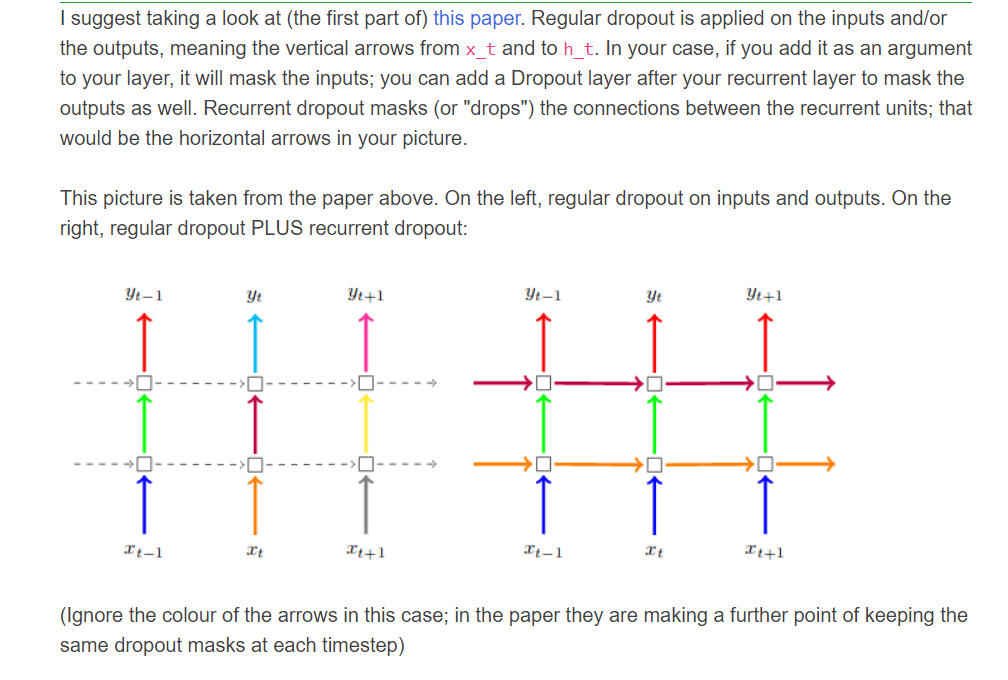

In [ ]:
# Power Scheduling

def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 ** (epoch / s)
  return exponential_decay_fn

exponential_defay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = tf.keras.models.load_model('sentiment_analyst_reviews_vietnamese.h5')

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_defay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('sentiment_analyst_reviews_vietnamese.h5', save_best_only=False)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_set, epochs=10, validation_data=valid_set, 
                    callbacks=[checkpoint_cb])

Epoch 1/10
1563/1563 [==============================] - 424s 267ms/step - loss: 0.1547 - accuracy: 0.9457 - val_loss: 0.1684 - val_accuracy: 0.9431
Epoch 2/10
1563/1563 [==============================] - 406s 260ms/step - loss: 0.1538 - accuracy: 0.9465 - val_loss: 0.1636 - val_accuracy: 0.9406
Epoch 3/10
1563/1563 [==============================] - 408s 261ms/step - loss: 0.1524 - accuracy: 0.9469 - val_loss: 0.1686 - val_accuracy: 0.9390
Epoch 4/10
1563/1563 [==============================] - 402s 257ms/step - loss: 0.1504 - accuracy: 0.9471 - val_loss: 0.1733 - val_accuracy: 0.9362
Epoch 5/10
1563/1563 [==============================] - 406s 260ms/step - loss: 0.1493 - accuracy: 0.9480 - val_loss: 0.1624 - val_accuracy: 0.9414
Epoch 6/10
1563/1563 [==============================] - 403s 258ms/step - loss: 0.1478 - accuracy: 0.9485 - val_loss: 0.1787 - val_accuracy: 0.9406
Epoch 7/10
1563/1563 [==============================] - 407s 260ms/step - loss: 0.1466 - accuracy: 0.9493 - val_

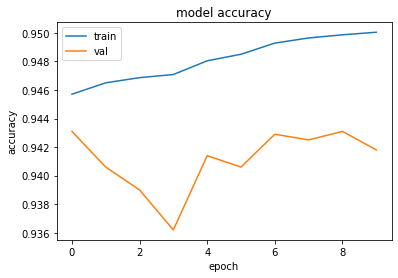

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

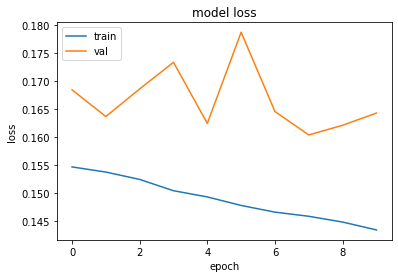

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_set)

560/560 [==============================] - 12s 22ms/step - loss: 0.1641 - accuracy: 0.9404


[0.16412246227264404, 0.9404143691062927]

In [ ]:
model.save('sentiment_analyst_reviews_vietnamese.h5')

In [ ]:
from google.colab import files
files.download('sentiment_analyst_reviews_vietnamese.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
preprocess_truncated_vocabulary[1]

b'v\xc3\xa0'

In [ ]:
# This code if use tokenize
f = open('vocabulary.txt', 'a')
for word in preprocess_truncated_vocabulary:
  f.write(str(word, 'utf-8') + '\n')
f.close()

In [ ]:
negative_review = 'mình check in nhận phỏng khoảng 5h chiều nhưng khi vào phòng thì sàn và dép vẫn còn ướt rèm chưa đủ rộng để che kính hết cửa kính nên giảm đi sự riêng tư.'
positive_review = 'Sạch sẽ , trẻ trung , có thang máy di chuyển, gần bến xe liên tỉnh, phù hợp cho các bạn thuê xe đi , vì đi bộ ra Hồ Xuân Hương hay chợ thì k đi bộ được đâu nhé ạ .Lễ tân dễ thương'

In [ ]:
bytes_negative = convert_string_to_byte(negative_review).numpy().split()
bytes_positive = convert_string_to_byte(positive_review).numpy().split()

In [ ]:
bytes_negative 

In [ ]:
neg = tf.constant(bytes_negative)
pos = tf.constant(bytes_positive)

neg = tf.expand_dims(neg, axis=0)
pos = tf.expand_dims(pos, axis=0)

neg_review = table.lookup(neg)
pos_review = table.lookup(pos)

In [ ]:
neg_review

<tf.Tensor: shape=(1, 35), dtype=int64, numpy=
array([[ 424, 5286, 1210,  204, 8528,  337, 7127,  561,   34,   28,   44,
           3,  740,  406,    1,  985,  329,  371,  720,  784,  578,  192,
         222,   31, 1357,  669,  425,   89,  669,  131,  724,   55,   40,
         473, 9339]])>

In [ ]:
neg_review[0].numpy()

array([ 424, 5286, 1210,  204, 8528,  337, 7127,  561,   34,   28,   44,
          3,  740,  406,    1,  985,  329,  371,  720,  784,  578,  192,
        222,   31, 1357,  669,  425,   89,  669,  131,  724,   55,   40,
        473, 9339])

In [ ]:
for word_index in neg_review[0].numpy():
  if word_index > num_oov_buckets:
    for word in neg.numpy()[0]:
      print(convert_byte_to_string(word), end = ' ')
    break
  else:
    print(convert_byte_to_string(truncated_vocabulary[word_index]) or num_oov_buckets, end=' ')

mình mình check in nhận phỏng khoảng 5h chiều nhưng khi vào phòng thì sàn và dép vẫn còn ướt rèm chưa đủ rộng để che kính hết cửa kính nên giảm đi sự riêng tư. 

In [ ]:
pos_review

<tf.Tensor: shape=(1, 46), dtype=int64, numpy=
array([[1063,   33, 8796,  412,  180, 8796,    7,  247,  148,  446, 2725,
          71, 3246,  153,  413, 7582,  525,  250,   17,   26,   62, 1814,
         153,   55, 8796,   85,   55,   80,  108, 1353, 9149, 3933,  902,
        1796,  740, 1201,   55,   80,   21,  913, 6054, 5802, 5385,  103,
         143,  851]])>

In [ ]:
for word_index in pos_review[0].numpy():
  if word_index > num_oov_buckets:
    for word in pos.numpy()[0]:
      print(convert_byte_to_string(word), end = ' ')
    break
  else:
    print(convert_byte_to_string(truncated_vocabulary[word_index]) or num_oov_buckets, end=' ')

Sạch sẽ Sạch sẽ , trẻ trung , có thang máy di chuyển, gần bến xe liên tỉnh, phù hợp cho các bạn thuê xe đi , vì đi bộ ra Hồ Xuân Hương hay chợ thì k đi bộ được đâu nhé ạ .Lễ tân dễ thương 

In [ ]:
y_pred_pos = model.predict(pos_review)
y_pred_neg = model.predict(neg_review)

1/1 [==============================] - 0s 19ms/step


In [ ]:
y_pred_pos

array([[0.92101175]], dtype=float32)

In [ ]:
y_pred_neg

array([[0.02569689]], dtype=float32)